# Bayesian parameter inference of a WEST water quality model Tutorial

Tutorial for infering parameters in a WEST model environment. This example is composed by a simplified model as example. A synthetic dataset is created using the model as a set of known parameter values. This timeseries is modified by an stochastic error structure to simulate measurement error. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import timeit

sys.path.insert(0, 'C:\Users\localadmin.TUD278183\Desktop\GitProjects\pyWEST\AutomatedCall')
from Parallel_WESTRunningWrapper import ModelInstances

plt.style.use('ggplot')
%matplotlib inline

## Generating synthetic measured data (known measurement error and parameter vector)

The model is run under the following parameter vector: {'W_b': 10, 'n':0.08, 'VKL': 2, 'Kd1': 0.4, 'Kd2':0.3}. Measurements of Dissolved oxygen are taken at the last section of the model 'River_5'. This measurement is distorted given a known error structure (homoscedastic and autocorrelated). This simulates a mismatch of the model structure to the real dynamics and a certain measurement error.


In [47]:
# Setting up model
ModelInstance = ModelInstances(['Model_dummy_1'], modelPath = "C:\Users\localadmin.TUD278183\Desktop\GitProjects\pyWEST")

def ReadOutput(fileouputname, ModelNAME, TimeWindowStart = None, variable = None):
    Output = pd.read_csv('C:\Users\localadmin.TUD278183\Desktop\GitProjects\pyWEST\\' + ModelNAME +'\\' + fileouputname , sep = '\t', skiprows=[1], index_col=[0])
    if TimeWindowStart is not None:
        
        Ind = Output.index.tolist()
        TimefreqOutput = int(round((Ind[1]-Ind[0])*3600*24)) # frequency of communication output in seconds. NOTE: The communication in the WEST output should be a fraction of day and interpolated (with as many decimals as possible to avoid problems with drifting of the timeseries) e.g. hourly should be: 0.041666666666666664, avoid rounding to 0.041667          
        TimeEnlapsed = pd.date_range(pd.to_datetime(TimeWindowStart) ,periods = len(Output), freq = '{}S'.format(TimefreqOutput))
        Output.set_index(TimeEnlapsed, inplace = True)
    
    if variable is None:
        return Output
    else: 
        return Output[variable]

Running model for simulating synthetic data

Simulation time : 3.2962548099 seconds
{'n': 0.08, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 10}


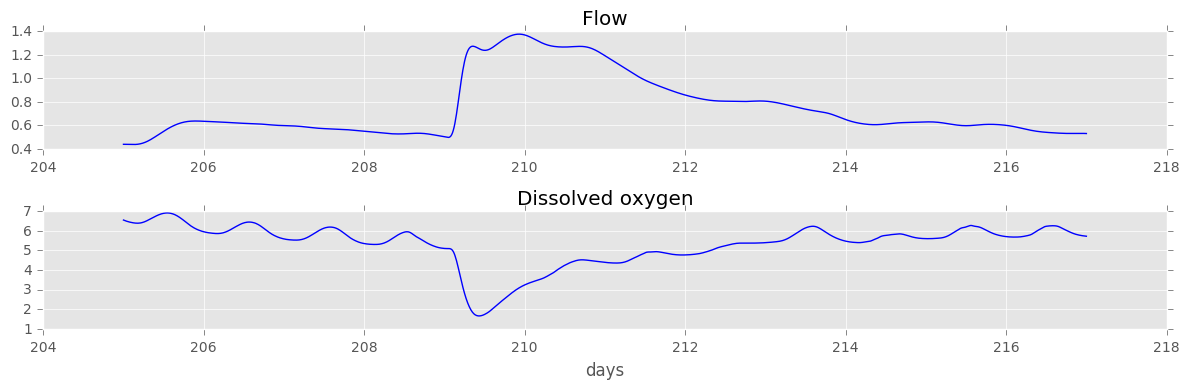

In [69]:
# Parameter definition

Timelist = {'StartTime':205,'StopTime':217} 
Parameterlist = {'W_b': 10, 'n':0.08, 'VKL': 2, 'Kd1': 0.4, 'Kd2':0.3}   

# Model Run
start_timer = timeit.default_timer()   
ModelInstance.model_run(Parameterlist, Timelist)

Output_Q = ReadOutput('Model_dummy_1.River_quantity_Dynamic.Simul.out.txt', 'Model_dummy_1', variable = '.River_5.Q')
Output_DO = ReadOutput('Model_dummy_1.Dynamic_water_quantity.Simul.1.out.txt', 'Model_dummy_1', variable = '.River_5.DO')

# Plot output and simulation time
print 'Simulation time : {} seconds'.format(timeit.default_timer() - start_timer)
print Parameterlist

fig, ax = plt.subplots(2,1, figsize=(12,4))
ax[0].plot(Output_Q, 'b')
ax[0].set_title('Flow')
ax[1].plot(Output_DO, 'b')
ax[1].set_title('Dissolved oxygen')
ax[1].set_xlabel('days')
plt.tight_layout()

We will infer 3 water quality parameters, Kd1, Kd2 and VKL. Those parameters relate to the degradation rates of fast-slow biodegradable matter and of the reareation rate respectively

#### Independent measurement error

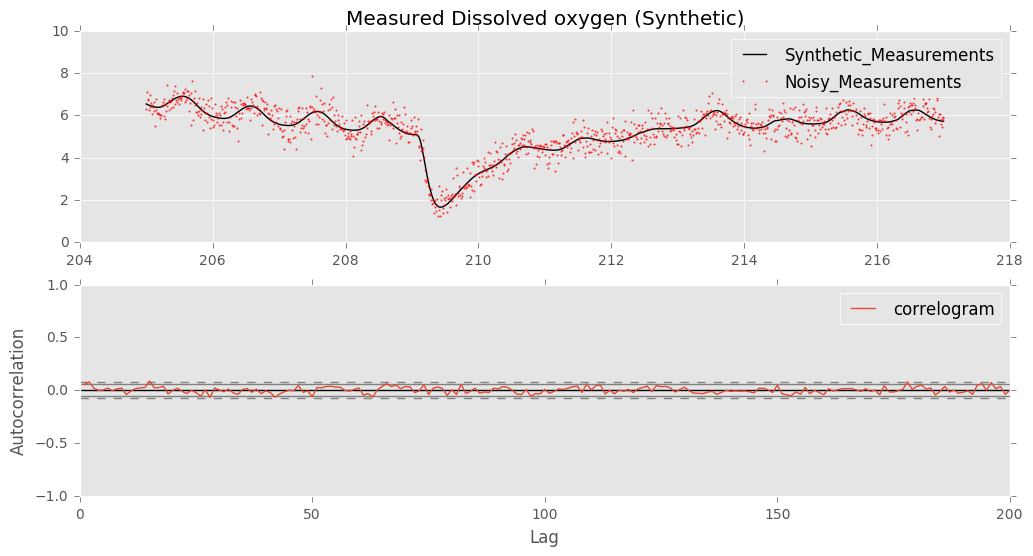

In [166]:
# Generate measurement scheme:
import math
np.random.seed(132)

# Generate autocorrelated homoscedastic error with exponential decay.
def AutocorrelatedError(mu, variance, correlationlength, samplesize):
    N = samplesize
    mean = np.zeros(N) + mu
    cov = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            x = abs(i-j) #time distance in timesteps
            cov[i,j] = float(variance) * math.exp(-x/(float(correlationlength)))
    return np.random.multivariate_normal(mean, cov), cov

#sampleError_iid, cov = AutocorrelatedError(0, 0.2, 0.000001, len(Output_DO))
sampleError_iid = np.random.normal(0,0.2**0.5,len(Output_DO))
Measured_DO_iid = Output_DO + sampleError_iid


#plotting measurements and noise added
fig, ax = plt.subplots(2,1, figsize = (12, 6))

ax[0].plot(Output_DO, 'k', label =  'Synthetic_Measurements')
ax[0].plot(Measured_DO_iid, 'r.', alpha = 0.6, ms = 2 , label =  'Noisy_Measurements')
ax[0].set_ylim((0,10))
ax[0].set_title('Measured Dissolved oxygen (Synthetic)')
#correlation plot
pd.tools.plotting.autocorrelation_plot(sampleError_iid, ax[1], label = 'correlogram')
ax[1].set_ylim((-1,1))
ax[1].set_xlim((0,200))

for axi in ax:
    axi.legend()

#### Autocorrelated error structure

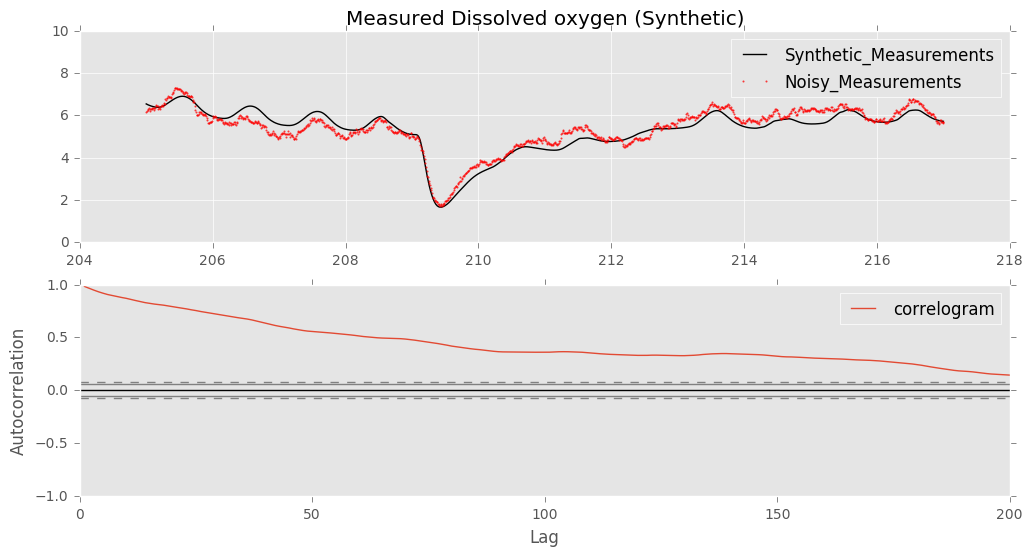

In [163]:
# Generate measurement scheme:
import math
np.random.seed(132)

# Generate autocorrelated homoscedastic error with exponential decay.
def AutocorrelatedError(mu, variance, correlationlength, samplesize):
    N = samplesize
    mean = np.zeros(N) + mu
    cov = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            x = abs(i-j) #time distance in timesteps
            cov[i,j] = float(variance) * math.exp(-x/(float(correlationlength)))
    return np.random.multivariate_normal(mean, cov), cov

sampleError, cov = AutocorrelatedError(0, 0.2, 100, len(Output_DO))
Measured_DO = Output_DO + sampleError

#plotting measurements and noise added
fig, ax = plt.subplots(2,1, figsize = (12, 6))

ax[0].plot(Output_DO, 'k', label =  'Synthetic_Measurements')
ax[0].plot(Measured_DO, 'r.', alpha = 0.6, ms = 2 , label =  'Noisy_Measurements')
ax[0].set_ylim((0,10))
ax[0].set_title('Measured Dissolved oxygen (Synthetic)')
#correlation plot
pd.tools.plotting.autocorrelation_plot(sampleError, ax[1], label = 'correlogram')
ax[1].set_ylim((-1,1))
ax[1].set_xlim((0,200))

for axi in ax:
    axi.legend()

## Parametric Inference. Building the bayesian model.

Our dynamic model $M_{L}$ is run through a set of dynamic inputs, $x(t)$, a set of initial conditions for the state variables $x_0$ and a vector of parameters, $\theta$. The dynamic model is accepted to produce a deterministic realization of the real variable. However our observations $\hat{Y}_{L}$ are subjected to a random measured error. Additionally, our model is supposed to not reproduce perfectly the underlaying dynamics, so a certain structural error will be induced.

Therefore, our observations are represented by a deterministic part (or dynamic simulator) and an stochastic part ($\epsilon$) which represents the observation and structural errors:

$$ \hat{Y}_{L} = M_{L}(x, x_0, \theta) + \epsilon $$

We propose a parametric shape for the stochastic term \epsilon. In this case we will assume that $\epsilon \sim N(0, \sigma^2)$. This is representing the model error as identically and independently distributed with mean zero and a certain standard deviation $\sigma$.

We will infer the value of the parameter vector $\theta$ and of the model error hyperparameters (in this case $\sigma$). Inference is done through a MCMC and an adaptative metropolis hastings algorithm. Which will explore the posterior probability density function. 

We use pymc 2 for the implementation of the model sampling.


### IID RESIDUALS

 [-----------------100%-----------------] 10000 of 10000 complete in 23560.0 secPlotting kd2
Plotting sigma
Plotting VKL
Plotting kd1
Simulation time METROPOLIS : 23569.3293022 seconds


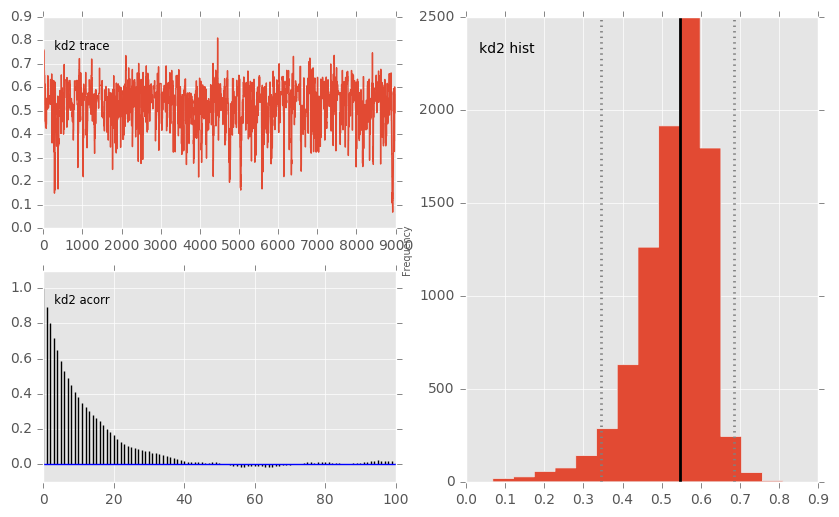

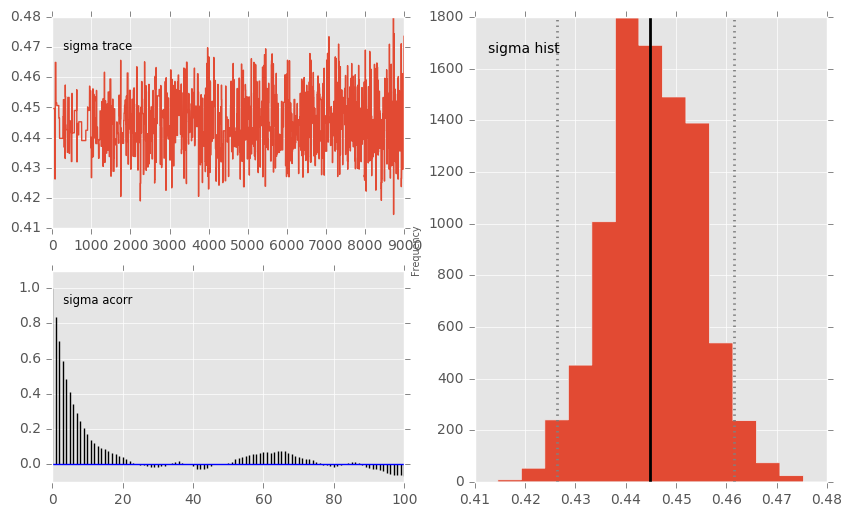

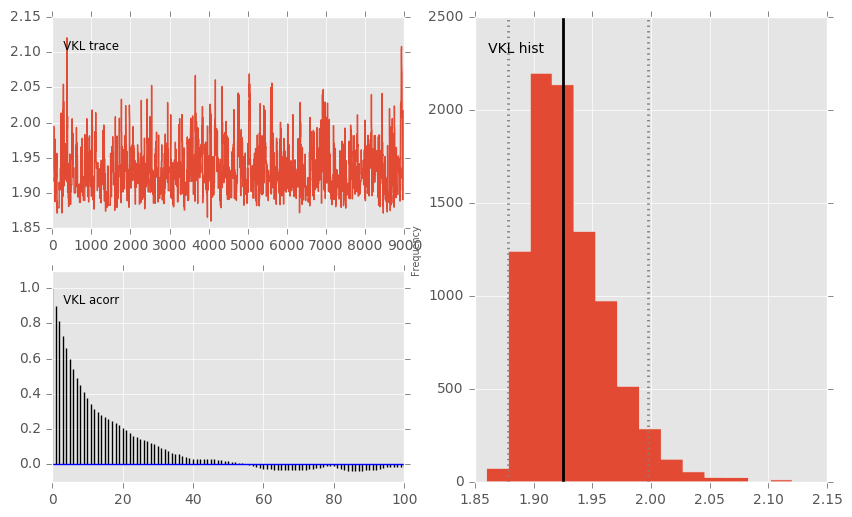

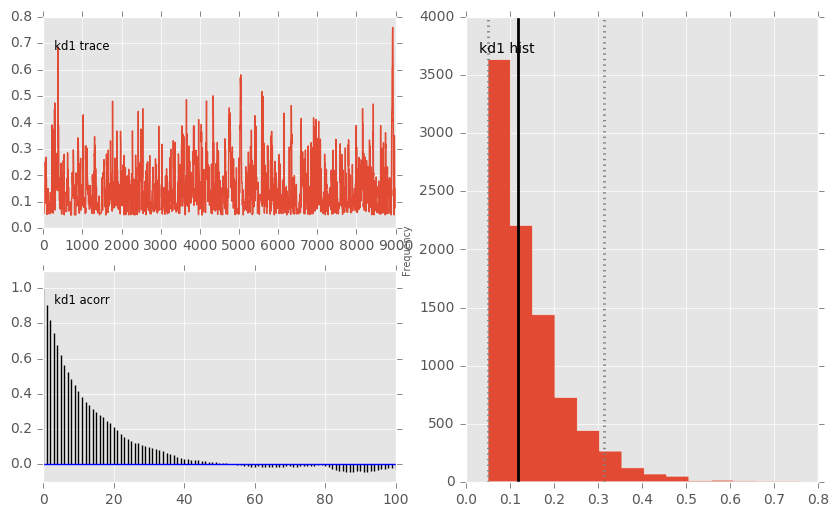

In [169]:
import pymc as pm

# PRIOR PARAMETERS
kd1 = pm.Uniform('kd1', 0.05, 2, value = 0.2)
kd2 = pm.Uniform('kd2', 0.05, 2, value = 0.2)
VKL = pm.Uniform('VKL', 0.1, 5, value = 1.5)

# Hyperparameters for error model
sigma = pm.Uniform('sigma', 0, 20, value = 0.5)
@pm.deterministic
def tau(sigma = sigma):
    return sigma**(-2)

# Model
@pm.deterministic
def Model(kd1 = kd1, kd2 = kd2, VKL = VKL):
 
    Timelist = {'StartTime':205,'StopTime':217} 
    Parameterlist = {'VKL': VKL, 'Kd1': kd1, 'Kd2':kd2, 'W_b': 10, 'n':0.08}   


    ModelInstance.model_run(Parameterlist, Timelist) 
    OutputM_DO = ReadOutput('Model_dummy_1.Dynamic_water_quantity.Simul.1.out.txt', 'Model_dummy_1', variable = '.River_5.DO')
    return np.array(OutputM_DO)
    
# Likelihood function

Like = pm.Normal('Like', mu = Model, tau = tau, value = np.array(Measured_DO_iid), observed = True) 


#%% IMPLEMENTATION WITH METROPOLIS HASTINGS FROM PYMC

start_timer = timeit.default_timer()

m = pm.MCMC([kd1, kd2, VKL, sigma, Like, Model], db='pickle', dbname='Inf_2.pickle')
m.use_step_method(pm.AdaptiveMetropolis,[kd1, kd2, VKL], delay = 100)

m.sample(10000, burn = 1000)

pm.Matplot.plot(m)

m.db.close()

print 'Simulation time METROPOLIS : {} seconds'.format(timeit.default_timer() - start_timer)

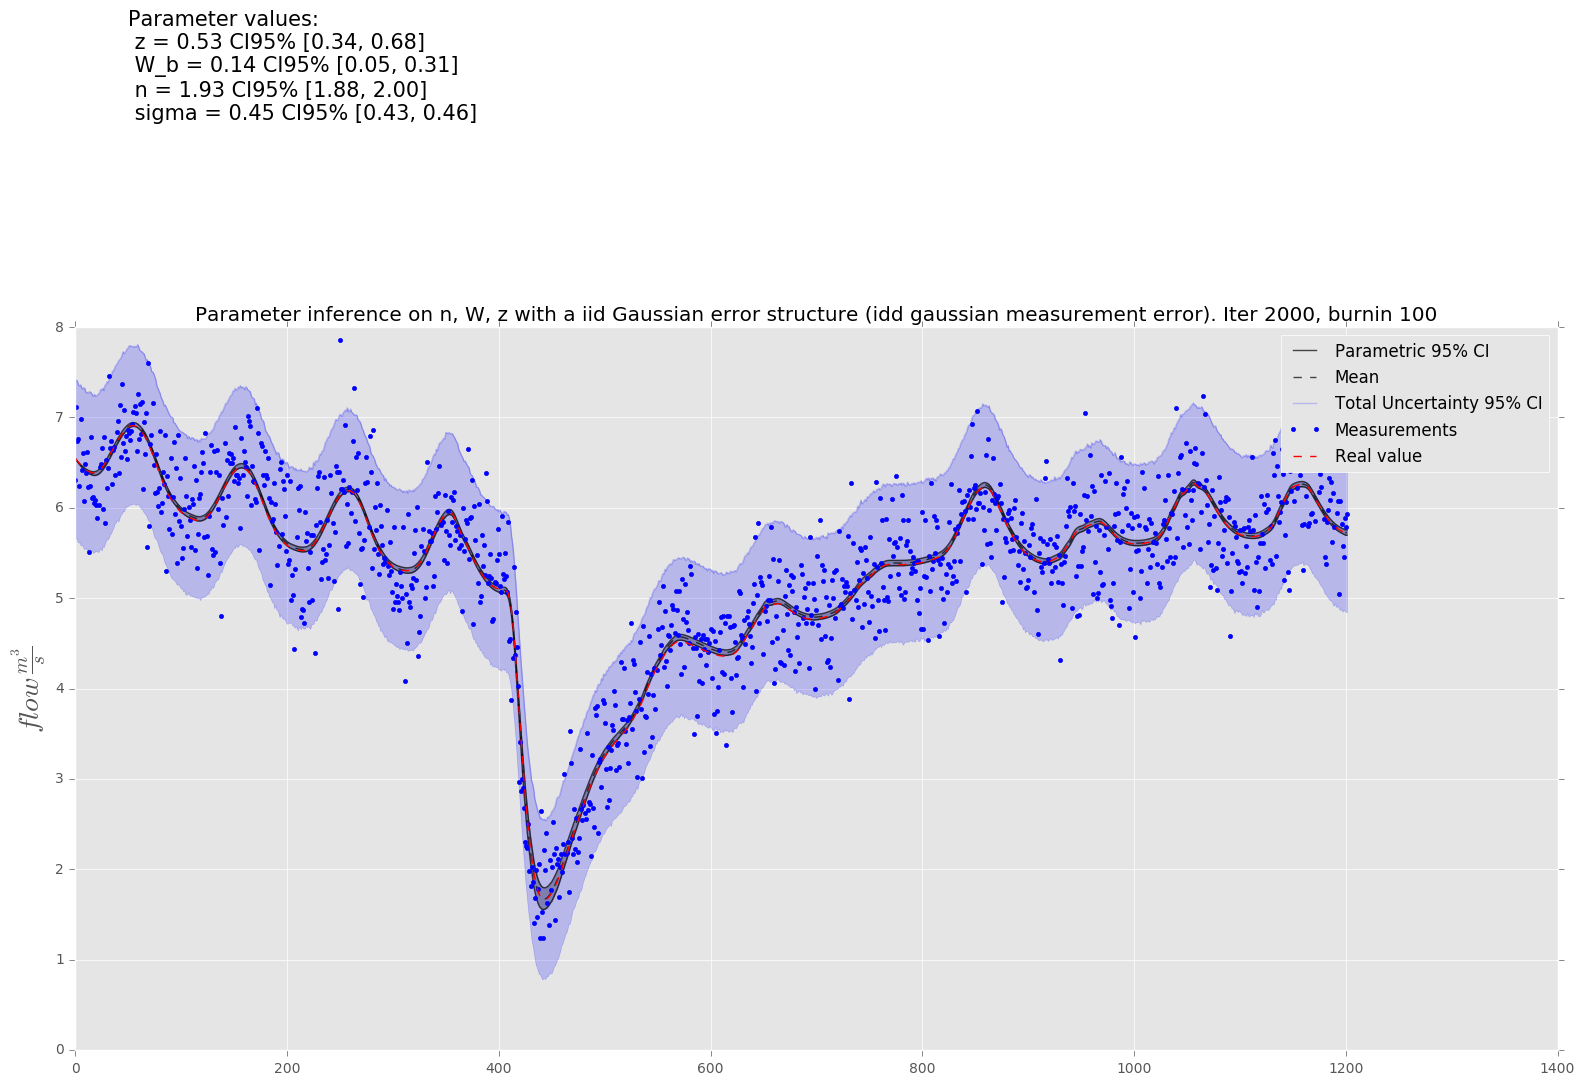

In [170]:
#sampling from posterior Propper bounds
burnin = 0

posterior = []
for i in range(len(m.trace('Model')[burnin:])):
    posterior.append(m.trace('Model')[i + burnin] + np.random.normal(0,m.trace('sigma')[i + burnin], len(m.trace('Model')[i + burnin])))
    post = np.array(posterior)
    
P95up = []
P95down = []

for i in range(np.shape(post)[1]):
    P95up.append(float(np.percentile(post[:,i],97.5)))
    P95down.append(float(np.percentile(post[:,i],2.5)))
    
fig = plt.figure(figsize=(16,8))

plt.plot(m.trace('Model').stats()['95% HPD interval'][0], 'k', alpha = 0.7, label = 'Parametric 95% CI')
plt.plot(m.trace('Model').stats()['95% HPD interval'][1], 'k', alpha = 0.7)
plt.fill_between(range(len(m.trace('Model').stats()['95% HPD interval'][1])), m.trace('Model').stats()['95% HPD interval'][0] , m.trace('Model').stats()['95% HPD interval'][1] , color='grey', alpha='0.7')
plt.fill_between(range(len(m.trace('Model').stats()['95% HPD interval'][1])), P95up, P95down, color='blue', alpha='0.2')

plt.plot(m.trace('Model').stats()['mean'], 'k--', alpha = 0.7, label = 'Mean')
plt.plot(P95up, 'b', alpha = 0.2, label = 'Total Uncertainty 95% CI')


plt.plot(Measured_DO_iid.tolist(), 'b.', label = 'Measurements')
plt.plot(Output_DO.tolist(), 'r--', label = 'Real value')

plt.legend()

plt.ylabel(r'$flow \/ \frac{m^3}{s} $', fontsize = 20)
plt.title('Parameter inference on n, W, z with a iid Gaussian error structure (idd gaussian measurement error). Iter 2000, burnin 100')
plt.tight_layout()

#plt.xlim((0,500))

plt.text(50, 10, 'Parameter values: \n z = {0:0.2f} CI95% [{1:0.2f}, {2:0.2f}] \n W_b = {3:0.2f} CI95% [{4:0.2f}, {5:0.2f}] \n n = {6:0.2f} CI95% [{7:0.2f}, {8:0.2f}] \n sigma = {9:0.2f} CI95% [{10:0.2f}, {11:0.2f}] \n '.format(
m.stats('kd2')['kd2']['mean'], 
m.stats('kd2')['kd2']['95% HPD interval'][0],
m.stats('kd2')['kd2']['95% HPD interval'][1],
m.stats('kd1')['kd1']['mean'],
m.stats('kd1')['kd1']['95% HPD interval'][0],
m.stats('kd1')['kd1']['95% HPD interval'][1],
m.stats('VKL')['VKL']['mean'],
m.stats('VKL')['VKL']['95% HPD interval'][0],
m.stats('VKL')['VKL']['95% HPD interval'][1],
m.stats('sigma')['sigma']['mean'],
m.stats('sigma')['sigma']['95% HPD interval'][0],
m.stats('sigma')['sigma']['95% HPD interval'][1]),
verticalalignment='bottom', horizontalalignment='left',
color='k', fontsize=15)

### AUTOCORRELATED RESIDUALS

 [-----------------100%-----------------] 10000 of 10000 complete in 16332.8 secPlotting VKL
Plotting kd1
Plotting kd2
Plotting sigma
Simulation time METROPOLIS : 16342.0894539 seconds


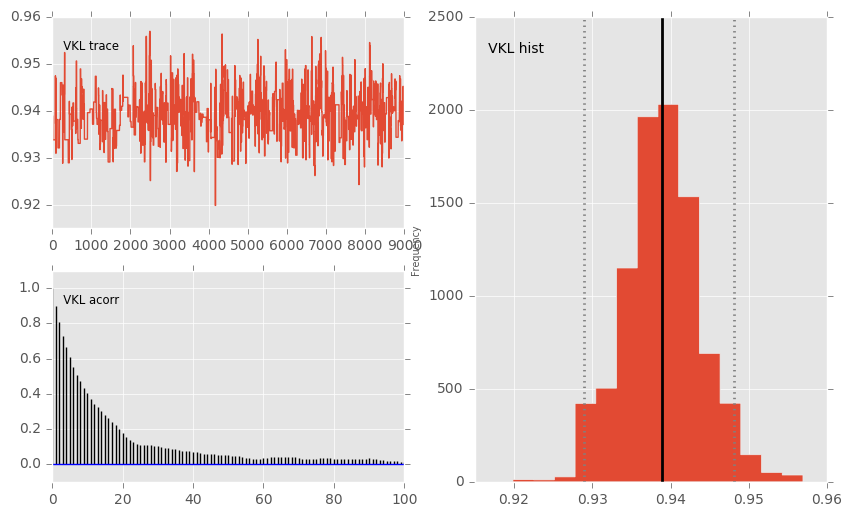

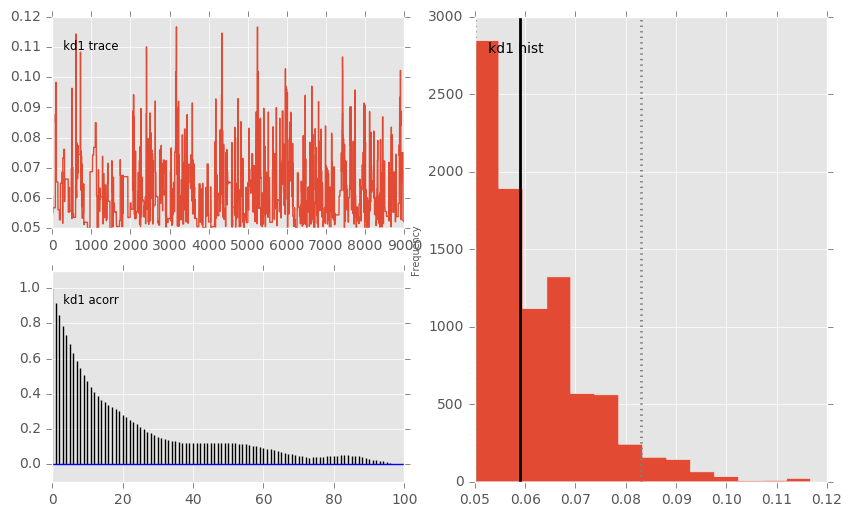

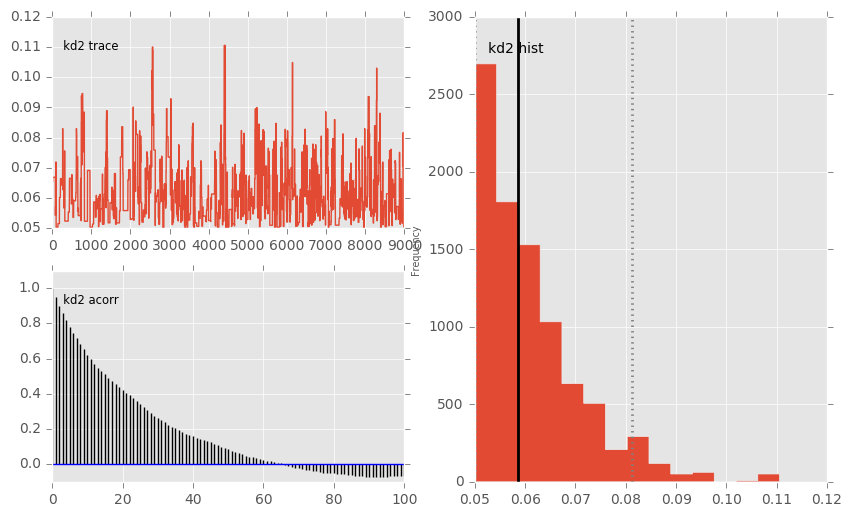

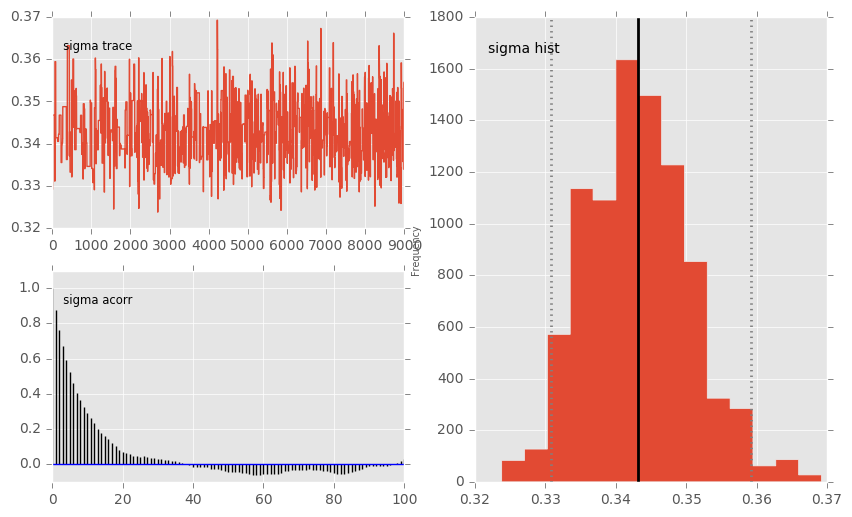

In [152]:
import pymc as pm

# PRIOR PARAMETERS
kd1 = pm.Uniform('kd1', 0.05, 2, value = 0.2)
kd2 = pm.Uniform('kd2', 0.05, 2, value = 0.2)
VKL = pm.Uniform('VKL', 0.1, 5, value = 1.5)

# Hyperparameters for error model
sigma = pm.Uniform('sigma', 0, 20, value = 0.5)
@pm.deterministic
def tau(sigma = sigma):
    return sigma**(-2)

# Model
@pm.deterministic
def Model(kd1 = kd1, kd2 = kd2, VKL = VKL):
 
    Timelist = {'StartTime':205,'StopTime':217} 
    Parameterlist = {'VKL': VKL, 'Kd1': kd1, 'Kd2':kd2}   

    ModelInstance.model_run(Parameterlist, Timelist) 
    OutputM_DO = ReadOutput('Model_dummy_1.Dynamic_water_quantity.Simul.1.out.txt', 'Model_dummy_1', variable = '.River_5.DO')
    return np.array(OutputM_DO)
    
# Likelihood function

Like = pm.Normal('Like', mu = Model, tau = tau, value = np.array(Measured_DO), observed = True) 


#%% IMPLEMENTATION WITH METROPOLIS HASTINGS FROM PYMC

start_timer = timeit.default_timer()

m = pm.MCMC([kd1, kd2, VKL, sigma, Like, Model], db='pickle', dbname='Inf_1.pickle')
m.use_step_method(pm.AdaptiveMetropolis,[kd1, kd2, VKL], delay = 100)

m.sample(10000, burn = 1000)

pm.Matplot.plot(m)

m.db.close()

print 'Simulation time METROPOLIS : {} seconds'.format(timeit.default_timer() - start_timer)

"\nplt.text(50, 10, 'Parameter values: \n z = {0:0.2f} CI95% [{1:0.2f}, {2:0.2f}] \n W_b = {3:0.2f} CI95% [{4:0.2f}, {5:0.2f}] \n n = {6:0.2f} CI95% [{7:0.2f}, {8:0.2f}] \n sigma = {9:0.2f} CI95% [{10:0.2f}, {11:0.2f}] \n '.format(\nm.stats('kd2')['kd2']['mean'], \nm.stats('kd2')['kd2']['95% HPD interval'][0],\nm.stats('kd2')['kd2']['95% HPD interval'][1],\nm.stats('kd1')['kd1']['mean'],\nm.stats('kd1')['kd1']['95% HPD interval'][0],\nm.stats('kd1')['kd1']['95% HPD interval'][1],\nm.stats('VKL')['VKL']['mean'],\nm.stats('VKL')['VKL']['95% HPD interval'][0],\nm.stats('VKL')['VKL']['95% HPD interval'][1],\nm.stats('sigma')['sigma']['mean'],\nm.stats('sigma')['sigma']['95% HPD interval'][0],\nm.stats('sigma')['sigma']['95% HPD interval'][1]),\nverticalalignment='bottom', horizontalalignment='left',\ncolor='k', fontsize=15)\n"

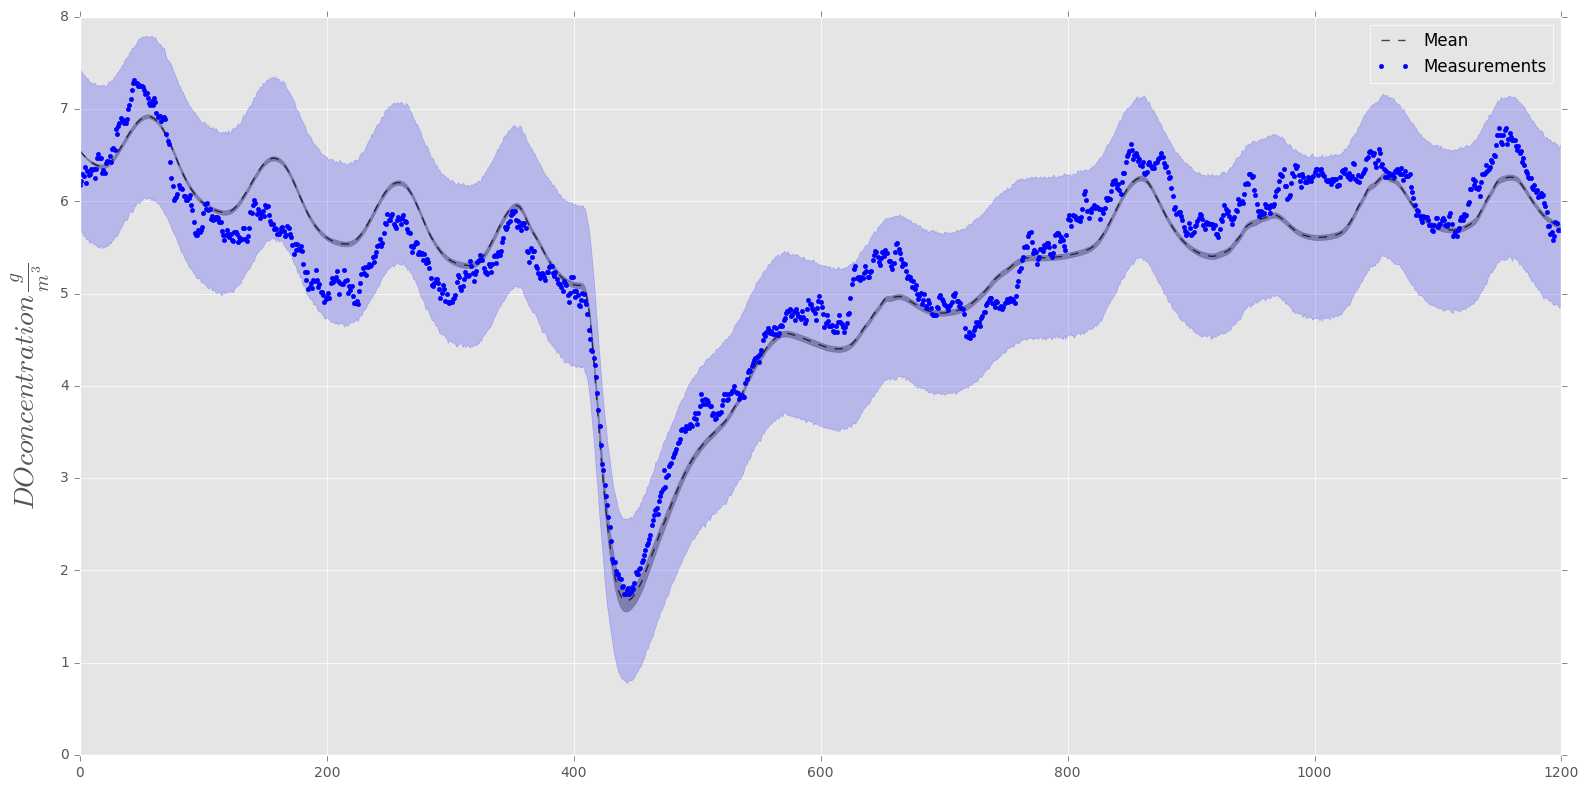

In [174]:
#sampling from posterior Propper bounds
burnin = 0

posterior = []
for i in range(len(m.trace('Model')[burnin:])):
    posterior.append(m.trace('Model')[i + burnin] + np.random.normal(0,m.trace('sigma')[i + burnin], len(m.trace('Model')[i + burnin])))
    post = np.array(posterior)
    
P95up = []
P95down = []

for i in range(np.shape(post)[1]):
    P95up.append(float(np.percentile(post[:,i],97.5)))
    P95down.append(float(np.percentile(post[:,i],2.5)))
    
fig = plt.figure(figsize=(16,8))

#plt.plot(m.trace('Model').stats()['95% HPD interval'][0], 'k', alpha = 0.7)
#plt.plot(m.trace('Model').stats()['95% HPD interval'][1], 'k', alpha = 0.7)
plt.fill_between(range(len(m.trace('Model').stats()['95% HPD interval'][1])), m.trace('Model').stats()['95% HPD interval'][0] , m.trace('Model').stats()['95% HPD interval'][1] , color='grey', alpha='0.7') #, label = 'Parametric 95% CI'
plt.fill_between(range(len(m.trace('Model').stats()['95% HPD interval'][1])), P95up, P95down, color='blue', alpha='0.2') #, label = 'Total Uncertainty 95% CI'

plt.plot(m.trace('Model').stats()['mean'], 'k--', alpha = 0.7, label = 'Mean')
#plt.plot(P95up, 'b', alpha = 0.2)


plt.plot(Measured_DO.tolist(), 'b.', label = 'Measurements')
#plt.plot(Output_DO.tolist(), 'r--')

plt.legend()

plt.ylabel(r'$DO concentration \/ \frac{g}{m^3} $', fontsize = 20)
#plt.title('Parameter inference on n, W, z with a iid Gaussian error structure (idd gaussian measurement error). Iter 2000, burnin 100')
plt.tight_layout()

plt.xlim((0,1200))

'''
plt.text(50, 10, 'Parameter values: \n z = {0:0.2f} CI95% [{1:0.2f}, {2:0.2f}] \n W_b = {3:0.2f} CI95% [{4:0.2f}, {5:0.2f}] \n n = {6:0.2f} CI95% [{7:0.2f}, {8:0.2f}] \n sigma = {9:0.2f} CI95% [{10:0.2f}, {11:0.2f}] \n '.format(
m.stats('kd2')['kd2']['mean'], 
m.stats('kd2')['kd2']['95% HPD interval'][0],
m.stats('kd2')['kd2']['95% HPD interval'][1],
m.stats('kd1')['kd1']['mean'],
m.stats('kd1')['kd1']['95% HPD interval'][0],
m.stats('kd1')['kd1']['95% HPD interval'][1],
m.stats('VKL')['VKL']['mean'],
m.stats('VKL')['VKL']['95% HPD interval'][0],
m.stats('VKL')['VKL']['95% HPD interval'][1],
m.stats('sigma')['sigma']['mean'],
m.stats('sigma')['sigma']['95% HPD interval'][0],
m.stats('sigma')['sigma']['95% HPD interval'][1]),
verticalalignment='bottom', horizontalalignment='left',
color='k', fontsize=15)
'''

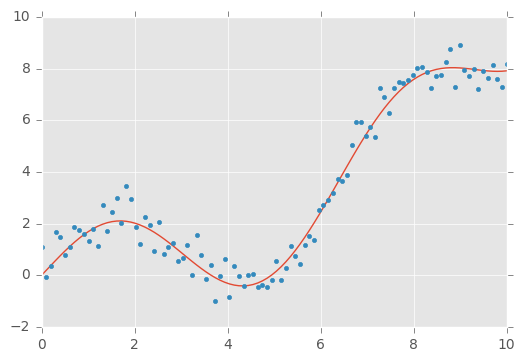

In [121]:
def mod(x, a, b):
    return a*np.sin(x) + b * x**2 - b * x

x = np.linspace(0,10,100)
y_out = mod(x, 2, 0.1)

y_measured = y_out + np.random.normal(0, 0.5, len(y_out))

plt.plot(x, y_out)
plt.plot(x, y_measured, '.')

 [-----------------100%-----------------] 1000 of 1000 complete in 0.1 secPlotting a
Plotting b
Plotting sigma
Simulation time METROPOLIS : 1.60119682985 seconds


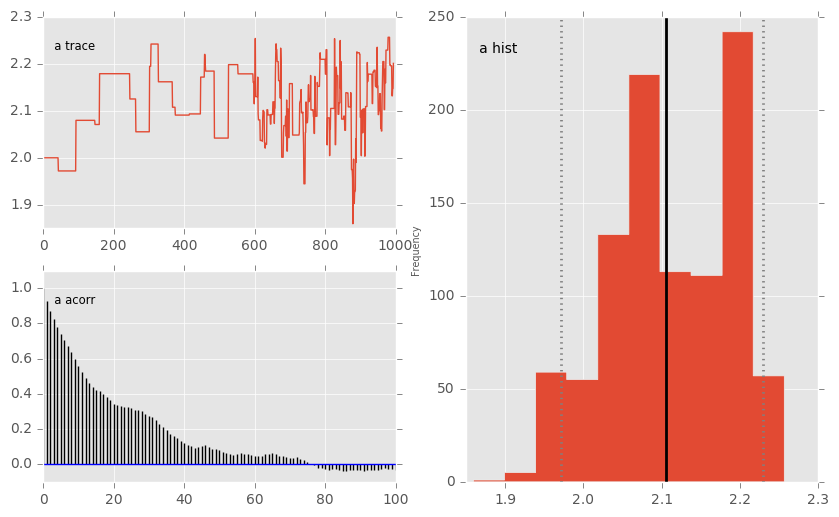

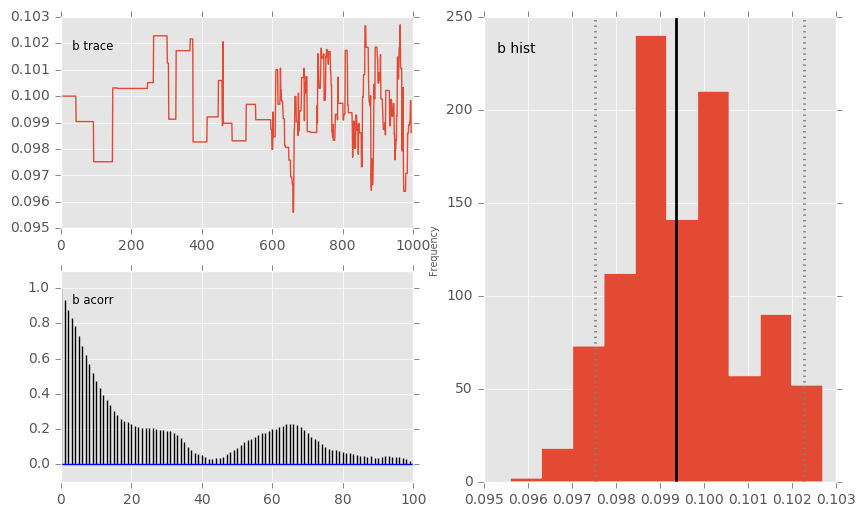

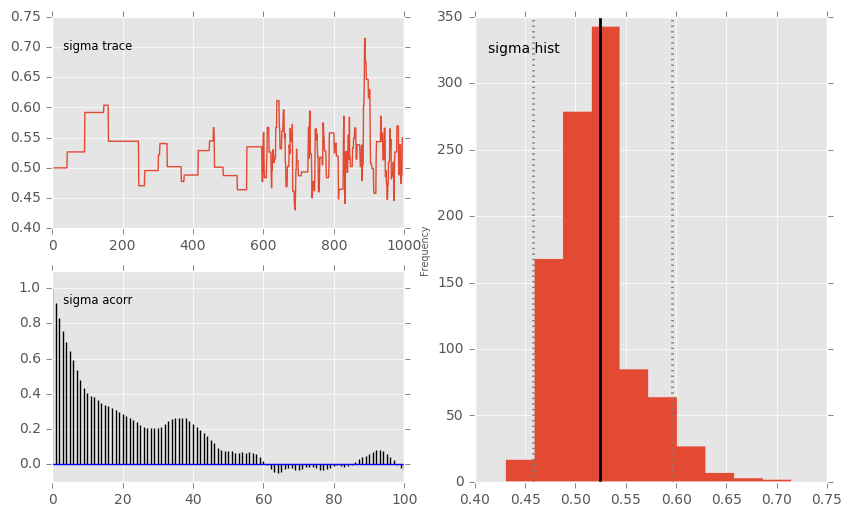

In [150]:
import pymc as pm

# PRIOR PARAMETERS
a = pm.Uniform('a', 0, 10, value = 2)
b = pm.Uniform('b', 0, 2, value = 0.1)


# Hyperparameters for error model
sigma = pm.Uniform('sigma', 0, 20, value = 0.5
                  )
@pm.deterministic
def tau(sigma = sigma):
    return sigma**(-2)

# Model
@pm.deterministic
def Model(a = a, b = b):
    return a*np.sin(x) + b * x**2 - b * x

   
# Likelihood function

Like = pm.Normal('Like', mu = Model, tau = tau, value = np.array(y_measured), observed = True) 


#%% IMPLEMENTATION WITH METROPOLIS HASTINGS FROM PYMC

start_timer = timeit.default_timer()

m = pm.MCMC([a, b, sigma, Like, Model], db='pickle', dbname='Inf_1.pickle')
m.use_step_method(pm.AdaptiveMetropolis,[a, b, sigma, Like, Model], delay = 100)

m.sample(1000, burn = 5)

pm.Matplot.plot(m)

m.db.close()

print 'Simulation time METROPOLIS : {} seconds'.format(timeit.default_timer() - start_timer)